# 3. Visualize Developers vs. Non-Developers

Visualize the mean and spread of the variables used in logistic regression:
- 925-hPa vorticity
- 975-hPa convergence
- 700-hPa specific humidity

and how they vary between the inner region (1.5 deg box) and outer region (5 deg box) and between developers, non-developers, and wet non-developers (TCWV>=50)

# Import statements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Load data

In [20]:
years_dev = np.arange(1981, 2020 + 1)
years_nondev = np.arange(1981, 2020 +1)

dev_list = [
    f"/data/keeling/a/smhenry2/Data/TCG/ERA5_processed_6hourly/developers_inner_outer_6hourly_{year}_ERA5.nc" for year in years_dev
]
nondev_list = [
    f"/data/keeling/a/smhenry2/Data/TCG/ERA5_processed_6hourly/non-developers_inner_outer_6hourly_16points_tcwv_{year}_ERA5.nc"
    for year in years_nondev
]


dev = xr.open_mfdataset(
    dev_list, combine="nested", concat_dim="track_point", join="outer"
).load()

nondev = xr.open_mfdataset(
    nondev_list, combine="nested", concat_dim="track_point", join="outer"
).load()

n_dev = len(np.unique(dev.id.values))
n_nondev = len(np.unique(nondev.id.values))

In [21]:
def remove_dry_vortex(ds, threshold=50):
    # keep only IDs where max tcwv>=50
    max_tcwv = ds["tcwv"].groupby(ds["id"]).max()
    
    max_tcwv_computed = max_tcwv.compute()
    
    valid_ids = (
        max_tcwv_computed
        .where(max_tcwv_computed >= threshold, drop=True)
        .coords["id"]
        .values
    )
    
    mask = ds["id"].isin(valid_ids).compute()
    return ds.where(mask, drop=True)


nondev_wet = remove_dry_vortex(nondev)
n_nondev_wet = len(np.unique(nondev_wet.id.values))

In [22]:
print(f"{len(np.unique(nondev.id.values))/len(np.unique(dev.id.values)):.2f} times as many non-developers than developers")

52.46 times as many non-developers than developers


In [23]:
print(f"{len(np.unique(nondev_wet.id.values))/len(np.unique(dev.id.values)):.2f} times as many wet (tcwv>=50mm) non-developers than developers")

16.57 times as many wet (tcwv>=50mm) non-developers than developers


# Plotting function

In [32]:
def plot_timeseries(
    data, var_name, title=None, ylim=None, save=False, savename=None, plot_mean=False
):
    var_dict = {
        "vo_925_inner": "inner 925-hPa vorticity (1/s)",
        "conv_975_inner": "inner 975-hPa convergence (1/s)",
        "q_700_inner": "inner 700-hPa specific humidity (kg/kg)",
        "vo_925_outer": "outer 925-hPa vorticity (1/s)",
        "conv_975_outer": "outer 975-hPa convergence (1/s)",
        "q_700_outer": "outer 700-hPa specific humidity (kg/kg)",
        "tcwv": "total column water vapor (mm)"
    }

    groups = data.groupby("id")
    ids = [id for id, idx in groups.groups.items() if len(idx) >= min_points]

    if len(ids) == 0:
        print(f"No storms have at least {min_points} points.")
        return

    print(f"Using {len(ids)} storms with ≥ {min_points} points")

    rel_hours = np.arange(0, 6 * min_points, 6)

    cmap = plt.get_cmap("jet", len(ids))
    
    plt.figure(figsize=(6, 4))

    all_vals = []

    for i, id in enumerate(ids):
        idx = groups.groups[id][:min_points]
        track = data.isel(track_point=idx)

        vals = np.asarray(track[var_name].values)

        if not plot_mean:
            plt.plot(
                rel_hours, vals, color=cmap(i), linewidth=1.5, alpha=0.7
            )

        all_vals.append(vals)

    all_vals = np.array(all_vals)

    if plot_mean:
        mean_vals = np.mean(all_vals, axis=0)
        p20_vals = np.percentile(all_vals, 20, axis=0)
        p80_vals = np.percentile(all_vals, 80, axis=0)

        plt.plot(rel_hours, mean_vals, color="k", linewidth=2.5)
        plt.fill_between(rel_hours, p20_vals, p80_vals, color="gray", alpha=0.3)

    plt.xlabel("Time since first point (hours)")
    plt.ylabel(var_dict[var_name])
    plt.ylim(ylim)
    plt.xlim(0, 6 * (min_points - 1))
    plt.grid(True, alpha=0.4)
    plt.title(title)
    plt.tight_layout()

    if save:
        plt.savefig("./figures/" + savename)

    plt.show()


def plot_dev_vs_nondev_timeseries(
    ax, data_dev, data_nondev, var_name, data_nondev_wet=None, 
    title=None, ylim=None
):
    var_dict = {
        "vo_925_inner": "925-hPa vorticity (1/s)",
        "conv_975_inner": "975-hPa convergence (1/s)",
        "q_700_inner": "700-hPa specific humidity (kg/kg)",
        "vo_925_outer": "925-hPa vorticity (1/s)",
        "conv_975_outer": "975-hPa convergence (1/s)",
        "q_700_outer": "700-hPa specific humidity (kg/kg)",
        "tcwv": "total column water vapor (mm)",
    }

    rel_hours = np.arange(0, 6 * min_points, 6)

    groups = data_dev.groupby("id")
    ids = [id for id, idx in groups.groups.items() if len(idx) >= min_points]

    if len(ids) > 0:
        all_vals = []
        for id in ids:
            idx = groups.groups[id][:min_points]
            track = data_dev.isel(track_point=idx)
            all_vals.append(track[var_name].values)

        all_vals = np.asarray(all_vals)

        mean_vals = np.mean(all_vals, axis=0)
        p20_vals = np.percentile(all_vals, 20, axis=0)
        p80_vals = np.percentile(all_vals, 80, axis=0)

        ax.plot(rel_hours, mean_vals, color="tab:orange", lw=2.5, label="developers")
        ax.fill_between(rel_hours, p20_vals, p80_vals,
                        color="tab:orange", alpha=0.3)

    groups = data_nondev.groupby("id")
    ids = [id for id, idx in groups.groups.items() if len(idx) >= min_points]

    if len(ids) > 0:
        all_vals = []
        for id in ids:
            idx = groups.groups[id][:min_points]
            track = data_nondev.isel(track_point=idx)
            all_vals.append(track[var_name].values)

        all_vals = np.asarray(all_vals)

        mean_vals = np.mean(all_vals, axis=0)
        p20_vals = np.percentile(all_vals, 20, axis=0)
        p80_vals = np.percentile(all_vals, 80, axis=0)

        ax.plot(rel_hours, mean_vals, color="tab:blue", lw=2.5, label="non-developers")
        ax.fill_between(rel_hours, p20_vals, p80_vals,
                        color="tab:blue", alpha=0.3)


    if data_nondev_wet is not None:
        groups = data_nondev_wet.groupby("id")
        ids = [id for id, idx in groups.groups.items() if len(idx) >= min_points]
    
        if len(ids) > 0:
            all_vals = []
            for id in ids:
                idx = groups.groups[id][:min_points]
                track = data_nondev_wet.isel(track_point=idx)
                all_vals.append(track[var_name].values)
    
            all_vals = np.asarray(all_vals)
    
            mean_vals = np.mean(all_vals, axis=0)
            p20_vals = np.percentile(all_vals, 20, axis=0)
            p80_vals = np.percentile(all_vals, 80, axis=0)
    
            ax.plot(rel_hours, mean_vals, color="tab:green", lw=2.5, label="non-developers, TCWV>=50")
            ax.fill_between(rel_hours, p20_vals, p80_vals,
                            color="tab:green", alpha=0.3)


    ax.set_xlim(0, 6 * (min_points - 1))
    ax.set_ylim(ylim)
    ax.set_title(title)
    ax.set_ylabel(var_dict[var_name])
    ax.grid(True, alpha=0.4)

## Plot

How does the temporal evolution vary between developers and non-developers for vorticity, convergence, and specific humidity within the inner region and the outer region?

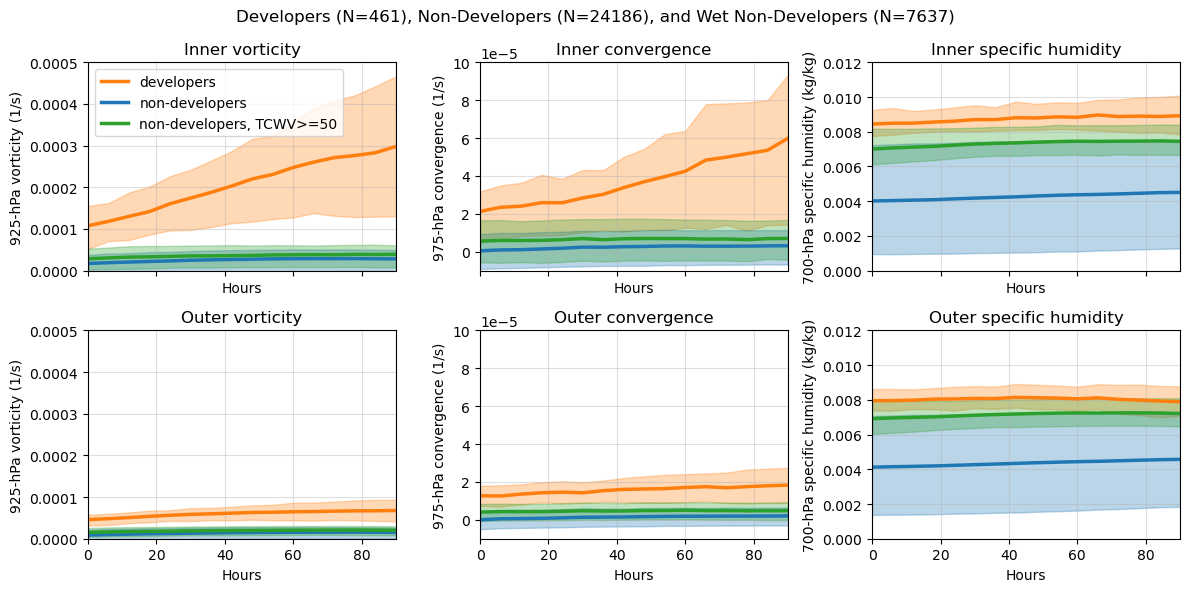

In [34]:
min_points = 16

fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True)
axs = axs.flatten()

plot_dev_vs_nondev_timeseries(
    axs[0], dev, nondev, "vo_925_inner", data_nondev_wet=nondev_wet,
    title="Inner vorticity", ylim=[0, 5e-4]
)

plot_dev_vs_nondev_timeseries(
    axs[3], dev, nondev, "vo_925_outer", data_nondev_wet=nondev_wet,
    title="Outer vorticity", ylim=[0, 5e-4]
)

plot_dev_vs_nondev_timeseries(
    axs[1], dev, nondev, "conv_975_inner", data_nondev_wet=nondev_wet,
    title="Inner convergence", ylim=[-1e-5, 1e-4]
)

plot_dev_vs_nondev_timeseries(
    axs[4], dev, nondev, "conv_975_outer", data_nondev_wet=nondev_wet,
    title="Outer convergence", ylim=[-1e-5, 1e-4]
)

plot_dev_vs_nondev_timeseries(
    axs[2], dev, nondev, "q_700_inner", data_nondev_wet=nondev_wet,
    title="Inner specific humidity", ylim=[0, 0.012]
)

plot_dev_vs_nondev_timeseries(
    axs[5], dev, nondev, "q_700_outer", data_nondev_wet=nondev_wet,
    title="Outer specific humidity", ylim=[0, 0.012]
)

for ax in axs:
    ax.set_xlabel("Hours")
    
axs[0].legend(loc="upper left")
plt.suptitle(f"Developers (N={n_dev}), Non-Developers (N={n_nondev}), and Wet Non-Developers (N={n_nondev_wet})")
plt.tight_layout()
plt.savefig("./figures/dev_vs_non-dev_vs_wet-non-dev.png")
plt.show()